In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.mixture import BayesianGaussianMixture

In [2]:
#圖片輸入時還是要做前處理，例如色彩平衡、增加對比等

def color_balance(picture):
    '''
    色彩平衡算法
    '''
    channel_mean = np.mean(picture,axis=(0,1),keepdims=True)
    k = channel_mean.mean()
    output = picture * (k/channel_mean)
    return np.clip(output,0,255).astype(np.uint8)

def upper_bound_contrast(picture,g):
    '''
    用來增加對比度，使得在GRB空間中的每一個點的遠離空間的正中央，也就是在任一維度中數值均遠離255/2(中央位置)
    g是調整係數介於0到1之間(包含首尾)
    
    公式由來:
    m(median):中央=255/2
    diff: 某點離中央的距離(方向由正負表示)
    abs(m/(diff))**g: diff的係數，用來調整diff的大小
    若g=1時，使得任意點都會被推移至255的位置，
    而g=0時，係數為1，diff不變，空間中的點不被推移，
    g介於0與1之間時，即介於上述兩種狀況之間
    
    目的:
    因為要做GMM聚類，資料點之間被推散分離可以穩定GMM的聚類結果
    '''
    m = 255/2
    diff = picture-m
    return (m + diff*abs(m/(diff))**g).astype(np.uint8)

def color_rescale(picture):
    '''
    正規化
    '''
    full_range = 255
    channel_min = np.min(picture,axis=(0,1),keepdims=True)
    channel_max = np.max(picture,axis=(0,1),keepdims=True)
    original_range = channel_max - channel_min
    return ((picture - channel_min)*(full_range/original_range)).astype(np.uint8)

def gaussian_blur(picture):
    '''
    高斯模糊，用以抹除雜訊造成分布上的偏差，使分布更穩定
    '''
    return cv2.GaussianBlur(picture.astype(np.uint8),(3,3),0)

In [3]:
def analyse_picture(n_clusters,*pictures):
    '''
    分析以及視覺化分割結果
    pictures: [(title,picture),...] 輸入多張圖片與其對應的標籤，以pair的形式
    圖片輸出:
        由左至右:依序列出pictures內的picture
        由上至下:文字圖片->圖片像素在RGB空間中的分布->RBG空間上的聚類結果->剔除不重要的clusters後剩下的clusters與文字圖片的對應->分割後的圖片->轉灰階結果
    '''
    figsize = 2.5
    small_marker_size = 0.75 #所有像素在RGB空間中分布點的marker size
    big_marker_size = 150 #聚類中心的marker size
    
    #第一張輸出圖片
    #橫軸是len(pictures)，縱軸是(文字圖片,圖片在RGB空間中的分布,RBG空間上的聚類結果,剔除不重要的clusters後剩下的clusters與文字圖片的對應,分割後的圖片,轉灰階結果)
    fig = plt.figure(figsize=(figsize*len(pictures),figsize*6))
    #依pictures順序繪製圖片
    for i,(title, picture) in enumerate(pictures):
        #繪製文字圖片，並加上對應的title
        ax = fig.add_subplot(6,len(pictures),i+1)
        ax.imshow(picture,interpolation='nearest')
        plt.title(title)
        plt.axis(False)
        
        #繪製RGB空間分布圖
        ax = fig.add_subplot(6,len(pictures),len(pictures)+i+1,projection='3d')
        #把圖片的長寬拉直成單一維度，每個像素都是三維空間中的一點，且其顏色座標就是其空間座標
        position = picture.reshape(-1,3)
        x = position[:,0]
        y = position[:,1]
        z = position[:,2]
        #繪製3D分布圖，且每個點依據其位置填入對應RGB顏色
        ax.scatter(x, y, z, s=small_marker_size, c=position/255, alpha=1)
        ax.set_xlim([0,255])
        ax.set_ylim([0,255])
        ax.set_zlim([0,255])
        ax.set_xlabel('R')
        ax.set_ylabel('G')
        ax.set_zlabel('B')
        plt.title(title)
        
        #GMM Model(sklearn.mixture.GaussianMixture的聚類成果普遍較差，故在此使用BayesianGaussianMixture)
        #聚類數量是分析的目標，故等於參數n_clusters
        gmm = BayesianGaussianMixture(n_components=n_clusters,max_iter = 2000)
        cate = gmm.fit_predict(position) #每個像素所屬的聚類編號
        centers = gmm.means_ #每個聚類的RGB空間位置
        color = centers[cate] #每個像素所屬的聚類顏色
        
        #繪製所有像素在RGB空間中的分布，並且依照其所屬聚類上色，並且加入該聚類的中心，以較大的marker顯示
        ax = fig.add_subplot(6,len(pictures),len(pictures)*2+i+1,projection='3d')
        #像素在RGB空間的分布
        x = position[:,0]
        y = position[:,1]
        z = position[:,2]
        ax.scatter(x, y, z, s=small_marker_size, c=color/255, alpha=1)
        #聚類中心在RGB空間的分布
        center_x = centers[:,0]
        center_y = centers[:,1]
        center_z = centers[:,2]
        ax.scatter(center_x, center_y, center_z, s=big_marker_size, c=centers/255, alpha=1)

        ax.set_xlim([0,255])
        ax.set_ylim([0,255])
        ax.set_zlim([0,255])
        ax.set_xlabel('R')
        ax.set_ylabel('G')
        ax.set_zlabel('B')
        plt.title(title)
        
        #依據所屬聚類，剔除不需要的像素顏色，以白色取代
        #保留下來的部分，建立兩種圖片，一個是依所屬聚類類別上色，另一個依原圖對應部分上色
        classified = np.full(position.shape,255) #依所屬聚類類別上色的圖片，暫時都由255填充
        reconstruct = np.full(position.shape,255) #依原圖對應部分上色，暫時都由255填充
        #因為圖片通常會有紅色的邊框或底線，故先剔除與紅色最有關(可以有不同的定義)的聚類
        #這邊選擇定義剔除掉所有聚類中心中R_channel數值最高前2者(通常包含白色的部分)，且紅色佔比最高的演算方式較不理想，故採用此演算方式
        R_chennel = centers[:,0]
        keep = np.isin(cate,np.argsort(R_chennel)[:2]) #篩選出欲保留對象，其他mask掉
        #利用mask的方式為圖片上色，但該圖片處於拉直的狀態，繪製前要在通過reshape
        classified[keep] = color[keep]
        reconstruct[keep] = position[keep]
        #繪製依所屬聚類類別上色的圖片
        ax = fig.add_subplot(6,len(pictures),len(pictures)*3+i+1)
        ax.imshow(classified.reshape(picture.shape),interpolation='nearest')
        plt.axis(False)
        plt.title(title)
        #繪製依原圖對應部分上色
        ax = fig.add_subplot(6,len(pictures),len(pictures)*4+i+1)
        ax.imshow(reconstruct.reshape(picture.shape),interpolation='nearest')
        plt.axis(False)
        plt.title(title)
        
        ax = fig.add_subplot(6,len(pictures),len(pictures)*5+i+1)
        gray = cv2.cvtColor(reconstruct.reshape(picture.shape).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        gray = 255 - gray #因為原本是白底黑字，考量到儲存空間，轉為黑底白字
        gray = np.where(gray>100,gray,0) #移除一些相對不清楚的灰色雜點
        ax.imshow(gray,interpolation='nearest',cmap='gray')
        plt.axis(False)
        plt.title(title)
        
    #顯示圖片
    plt.tight_layout()
    plt.show()

In [4]:
def example(imgs):
    for img in imgs:
        print('='*20+f'{img.with_suffix("").name[-1]}'+'='*20)
        original = plt.imread(img)
        #此前處理步驟是測試過後較好的組合方式
        blur = gaussian_blur(original) #先進行高斯模糊降低分布的離散程度
        rescale = color_rescale(blur) #正規化數值的區間，將稠密的分布拉散
        balance = color_balance(rescale) #色彩平衡，減少顏色偏差
        contrast = upper_bound_contrast(balance,0.6) #增加對比對，使其在RGB空間中更容易分離，參數0.6是嘗試過較適合的數值

        analyse_picture(5, #5是較為適當的分群數量
            ('original',original),
            ('blur',blur),
            ('rescale',rescale),
            ('balance',balance),
            ('contrast',contrast))

====================長====================


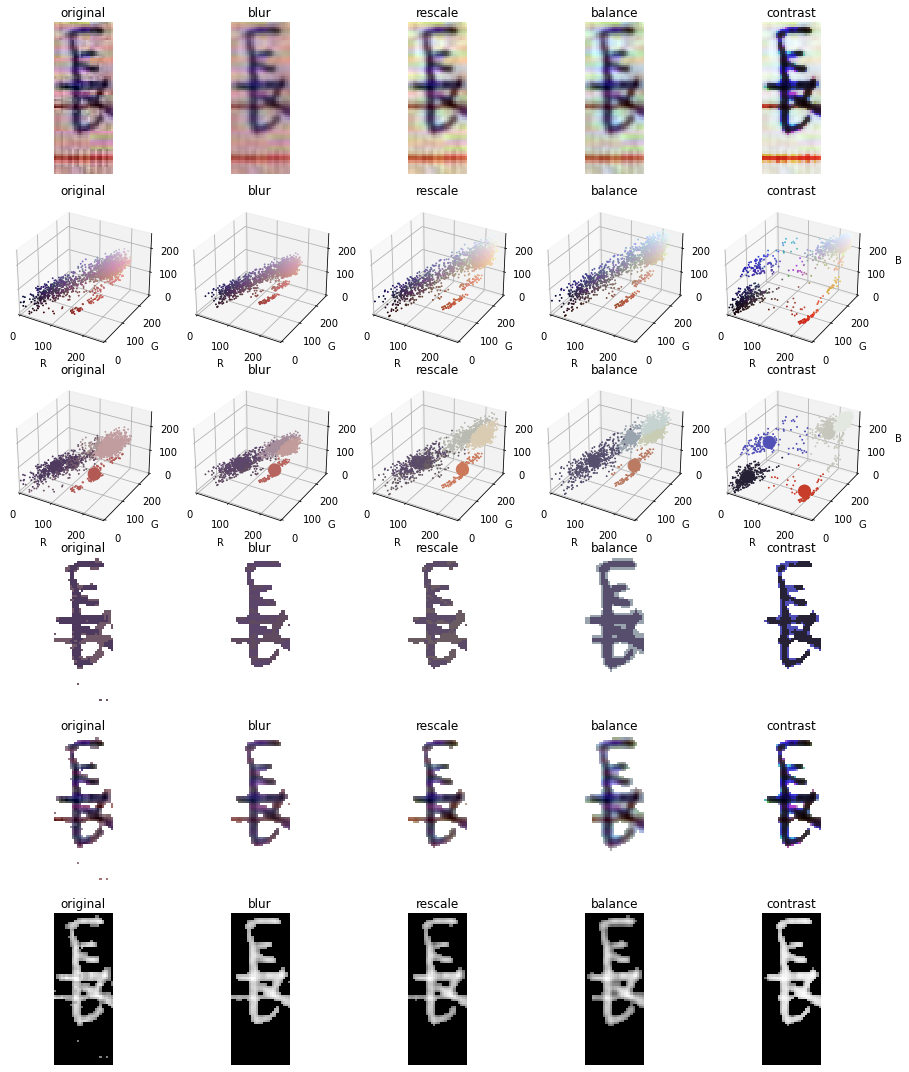

====================霞====================


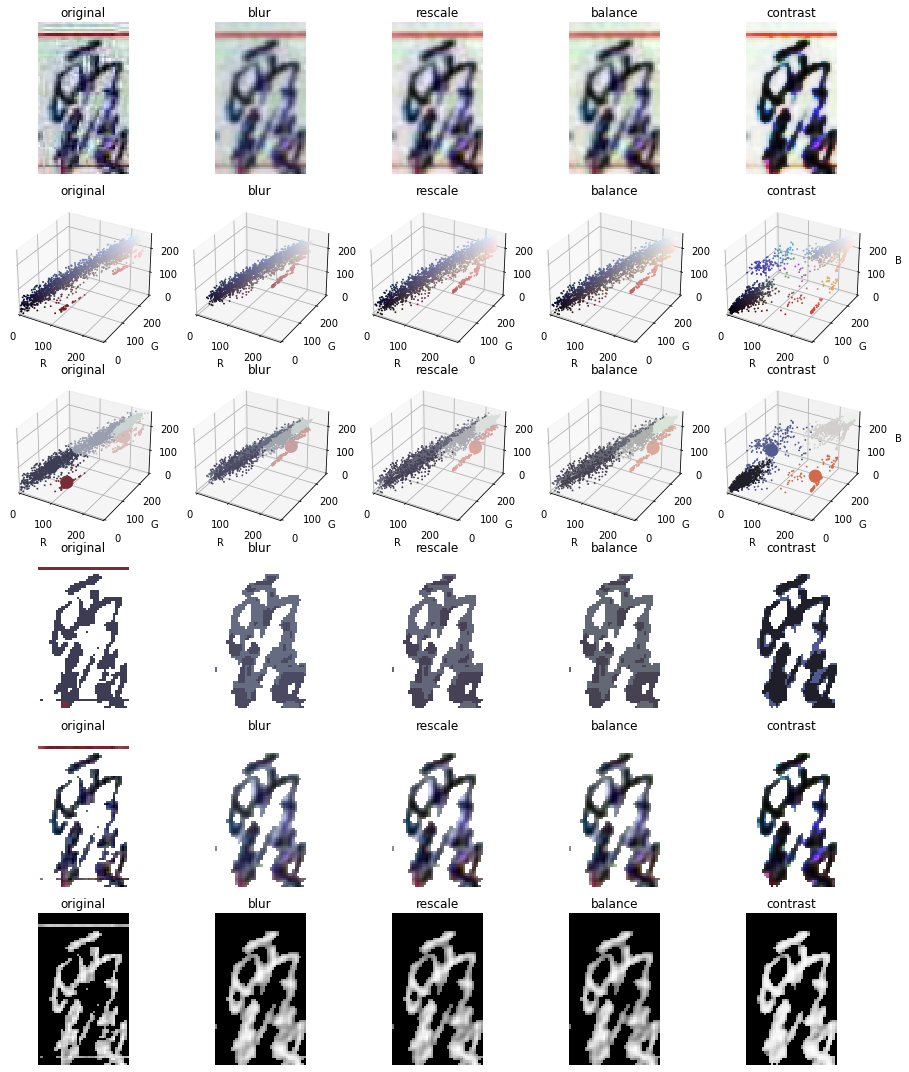

====================嘉====================


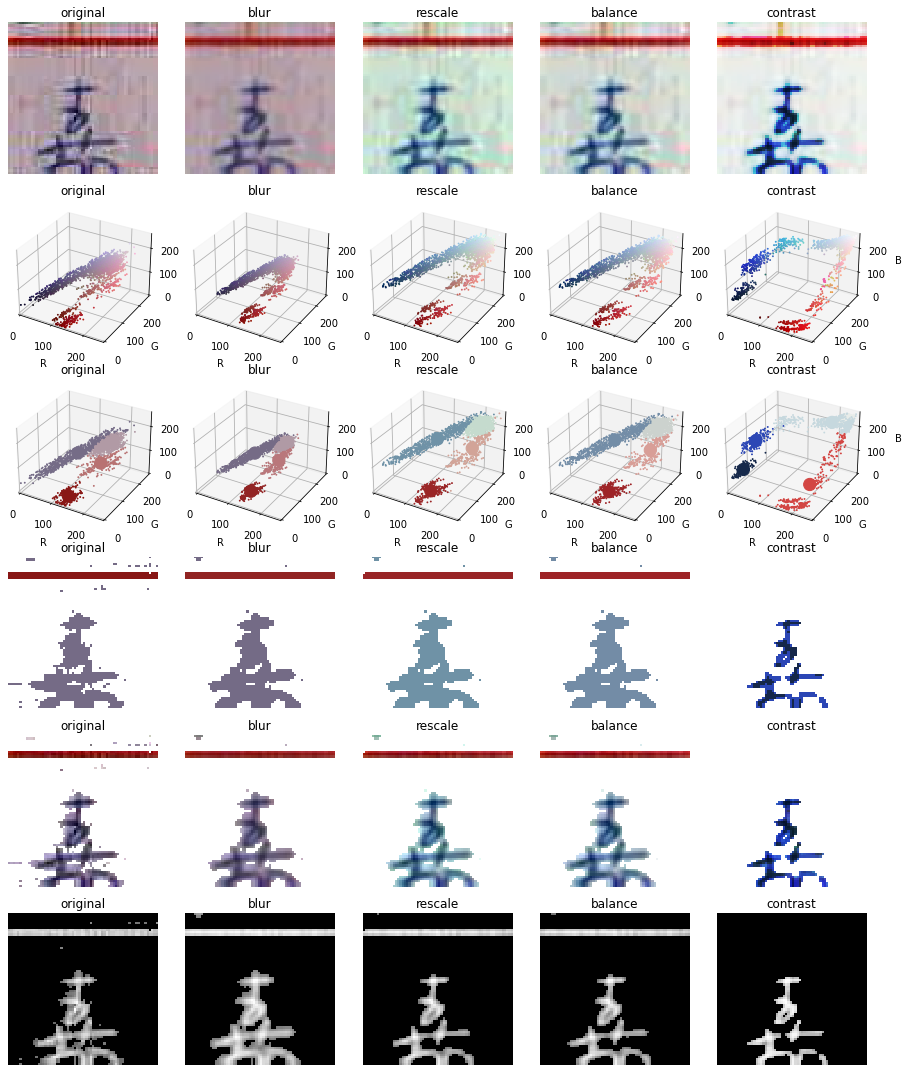

====================仁====================


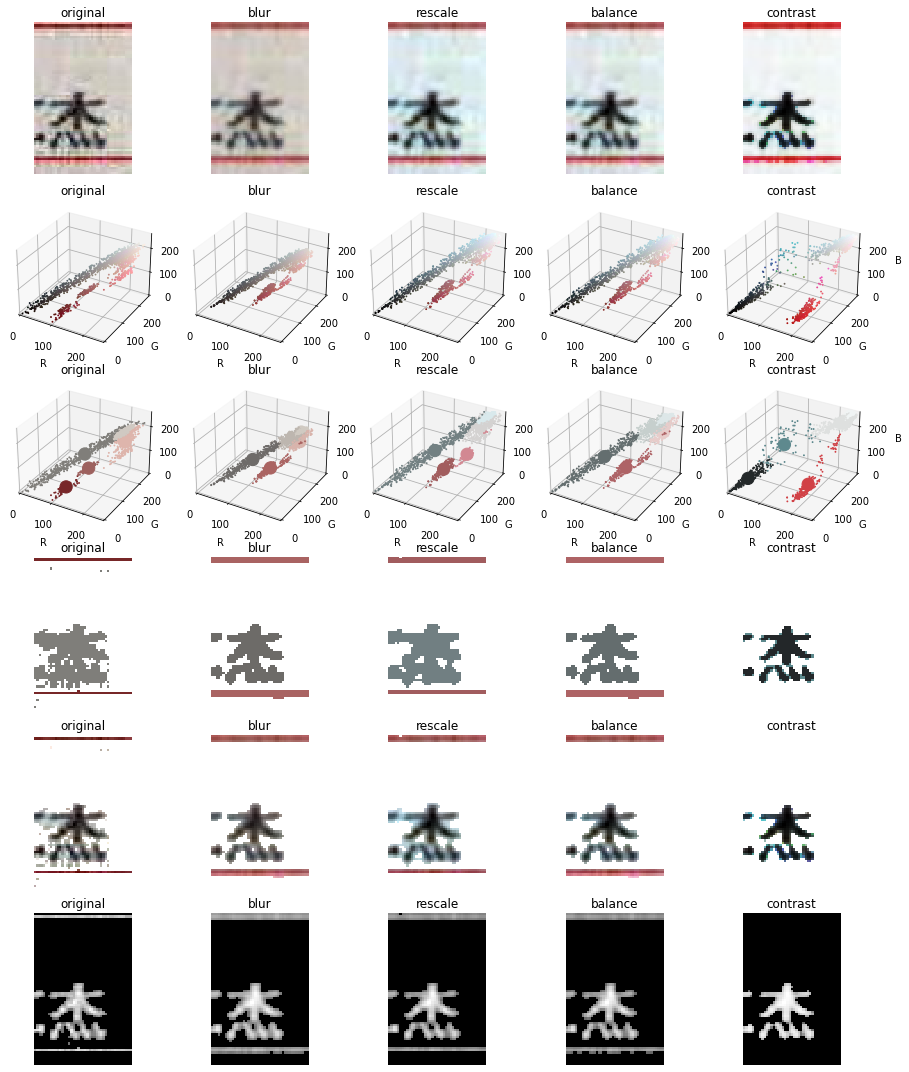

====================球====================


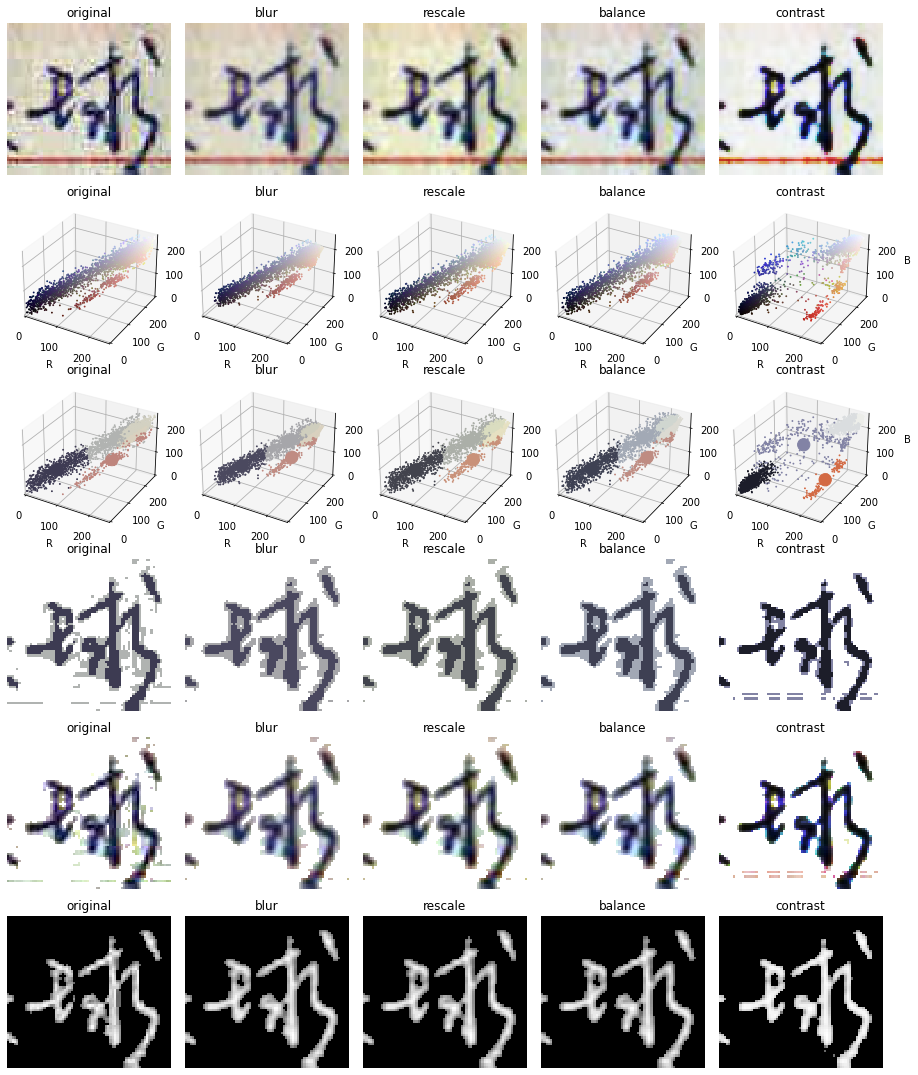

In [5]:
data = pathlib.Path('data')
imgs = list(data.joinpath('img').glob('*.jpg'))

example(imgs[:5])

In [6]:
#正式上線用以生產灰階圖片的code
def extract(picture):
    blur = gaussian_blur(picture)
    rescale = color_rescale(blur)
    balance = color_balance(rescale)
    contrast = upper_bound_contrast(balance,0.6)

    position = contrast.reshape(-1,3)
    gmm = BayesianGaussianMixture(n_components=5,max_iter = 2000)
    cate = gmm.fit_predict(position)
    centers = gmm.means_
    color = centers[cate]

    reconstruct = np.full(position.shape,255)
    R_chennel = centers[:,0]
    keep = np.isin(cate,np.argsort(R_chennel)[:2])
    reconstruct[keep] = position[keep]
    reconstruct = reconstruct.reshape(picture.shape).astype(np.uint8)
    gray = cv2.cvtColor(reconstruct, cv2.COLOR_RGB2GRAY)
    gray = 255 - gray
    gray = np.where(gray>100,gray,0)
    return gray

In [7]:
imgs = data.joinpath('img').glob('*.jpg')

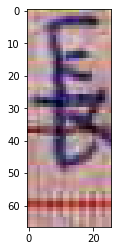

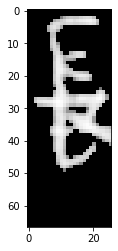

In [8]:
#由於不是所有的圖片都有好的成像結果，執行此部分程式碼檢視結果，再決定要不要儲存
#如果要得話執行下面的cell，不要的話再執行一次本cell以取得下一張圖片
img = next(imgs)
rgb = plt.imread(img)
gray = extract(rgb)
plt.imshow(rgb)
plt.show()
plt.imshow(gray,cmap='gray')
plt.show()

In [10]:
pair_img = data.joinpath('pair_img',img.with_suffix('').name[:-2])
pair_img.mkdir(exist_ok=True)
cv2.imwrite(pair_img.joinpath('rgb.jpg').as_posix(), cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR))
cv2.imwrite(pair_img.joinpath('gray.jpg').as_posix(), gray)

True